# Building A Model To Predict First Place Placement

In this part I aim to see I can identify the dependent variables that are associated with winning first place in a match of PUBG. In this step I will take the following steps.

1. Creating dummy variables by turning non first placements into 0
2. Drop irrelavant columns known by domain knowledge
3. Balance the dataset so 20% of the data is the desired output variable
4. Compute the variance inflation factor of each column to rule out colinearity in the data (https://etav.github.io/python/vif_factor_python.html)
5. Compute the information value of each variable to determine predictive power of each variable
6. Train-split-test the data
7. Run Logistic Regression and Random forest classifier, and compare scoring of each model weighed by auc score
and classification report 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

In [2]:
dfsolo_extra = pd.read_csv('extra_data.csv') 

Larger dataset extracted for machine learning purposes. Contains only solo game mode matches. 
Contains all team placements in a match, not just the top 50 like used in previous analysis.

In [3]:
#First place winners labeled '1', others labeled '0'
dfsolo_extra['team_placement'] = np.where(dfsolo_extra['team_placement'] == 1, 1, 0)

In [4]:
dfsolo_extra.describe()

,Unnamed: 0,game_size,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_id,team_placement
count,2.883169e+06,2.883169e+06,2883169.0,2.883169e+06,2883169.0,2.883169e+06,2.883169e+06,2.883169e+06,2.883169e+06,2.883169e+06,2.883169e+06,2.883169e+06
mean,6.900192e+06,9.247367e+01,1.0,6.159091e-02,0.0,8.819209e+02,1.159026e+03,1.125184e+02,8.973078e-01,5.162539e+03,1.000491e+05,1.086201e-02
std,3.997248e+06,5.864794e+00,0.0,2.539299e-01,0.0,1.837711e+03,4.886953e+03,1.624480e+02,1.567653e+00,2.337549e+06,2.862110e+01,1.036534e-01
min,4.940000e+02,1.400000e+01,1.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+05,0.000000e+00
25%,3.451921e+06,9.000000e+01,1.0,0.000000e+00,0.0,0.000000e+00,1.511720e+02,0.000000e+00,0.000000e+00,3.000000e+00,1.000240e+05,0.000000e+00
50%,6.875349e+06,9.400000e+01,1.0,0.000000e+00,0.0,0.000000e+00,6.884468e+02,6.800000e+01,0.000000e+00,9.000000e+00,1.000490e+05,0.000000e+00
75%,1.035488e+07,9.600000e+01,1.0,0.000000e+00,0.0,1.104030e+03,1.818461e+03,1.570000e+02,1.000000e+00,1.900000e+01,1.000740e+05,0.000000e+00
max,1.384900e+07,1.000000e+02,1.0,6.000000e+00,0.0,4.046806e+05,1.188375e+06,6.343000e+03,6.400000e+01,1.060798e+09,1.001210e+05,1.000000e+00


In [5]:
#Remove unnecessary columns
dfsolo_extra = dfsolo_extra.drop(['match_id','date', 'Unnamed: 0', 'game_size', 'match_mode', 
                                  'player_assists', 'team_id', 'party_size', 'player_name', 'player_dbno'], axis=1)

These columns were deemed unapplicable to a predictive model. 
Columns such as player assists or player_dbno (knockouts) don't apply because 
they are only relevant to non solo game modes. Game size remains releatively consistent.

In [6]:
#Sort by team placement so to easily extract the different labels
dfsolo_extra = dfsolo_extra.sort_values('team_placement')

In [7]:
#Checking how balanced the dataset is
dfsolo_extra.team_placement.value_counts()

0    2851852
1      31317
Name: team_placement, dtype: int64

In [8]:
#Checking to see that its sorted as desired
dfsolo_extra.head()

,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_placement
0,0.00000,170.954788,0,0,3.0,0
1916851,3526.60645,1253.575810,84,1,24.0,0
1916852,1905.33386,2060.950200,101,1,12.0,0
1916853,0.00000,170.131638,0,0,3.0,0
1916854,6778.08100,930.831700,293,3,25.0,0


In [9]:
dfsolo_extra.tail()

,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_placement
1458928,6673.66943,1562.07312,581,7,31.0,1
2234780,3374.28345,2793.30127,474,2,36.0,1
806218,3708.33447,3607.38428,1810,16,29.0,1
346896,3710.22632,3460.86255,275,2,32.0,1
782370,2142.30176,4894.12061,1089,11,32.0,1


In [10]:
#Balancing the dataset for model predictions. 12,567 first place winners, and 31,317 (4 times the winners) non first place.
dfsolo_balanced = dfsolo_extra.iloc[pd.np.r_[0:12567, -31317:0]]

In [11]:
dfsolo_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43884 entries, 0 to 782370
Data columns (total 6 columns):
player_dist_ride       43884 non-null float64
player_dist_walk       43884 non-null float64
player_dmg             43884 non-null int64
player_kills           43884 non-null int64
player_survive_time    43884 non-null float64
team_placement         43884 non-null int32
dtypes: float64(3), int32(1), int64(2)
memory usage: 2.2 MB


In [12]:
#Removing label from dependent variables

X = dfsolo_balanced
X = dfsolo_balanced.drop(['team_placement'], axis=1) 
X.shape

(43884, 5)

In [13]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,2.6,player_dist_ride
1,8.4,player_dist_walk
2,58.8,player_dmg
3,55.7,player_kills
4,11.1,player_survive_time


In [14]:
X_low_vif = X.drop(['player_kills', 'player_survive_time'], axis=1)

In [15]:
vif2 = pd.DataFrame()
vif2["VIF Factor2"] = [variance_inflation_factor(X_low_vif.values, i) for i in range(X_low_vif.shape[1])]
vif2["features2"] = X_low_vif.columns
vif2.round(1)

,VIF Factor2,features2
0,1.7,player_dist_ride
1,3.2,player_dist_walk
2,3.1,player_dmg


**Taking a look at the Variance Inflation Factor of the dependent variables, as expected we see player kills and player damage being high, meaning the two variables are explaining the same variance within the dataset. This means one variable needs to be removed, which I'll choose to remove player kills since damage it will provide a greater range of data than kills.**

**Secondly, player_survival_time was also causing high multicolinearlity**

https://etav.github.io/python/vif_factor_python.html

In [16]:
#Target variable / label

y = dfsolo_balanced.team_placement 
y.value_counts()

1    31317
0    12567
Name: team_placement, dtype: int64

In [17]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [18]:
final_iv, IV = data_vars(X_low_vif, y)
IV

C:\Users\Ameen\Miniconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
C:\Users\Ameen\Miniconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


,VAR_NAME,IV
0,player_dist_ride,1.169115
1,player_dist_walk,3.310659
2,player_dmg,5.691687


**Weight of evidence and information value (IV) are techniques to find high predictor variables. 
Values above .5 are considered to be too good to be true, but thats what we're left with this data, so it'll due.**

In [19]:
#Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_low_vif, y, test_size=0.3, random_state=42)

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve




def run_regression_accuracy(X_train, y_train, X_test, y_test):
  logreg = LogisticRegression() #Instantiate the Logistic Regression Model
  logreg.fit(X_train, y_train) #Fit
  y_pred = logreg.predict(X_test) #Predict
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  print('\nConfusion matrix: \n',cm)

  print('\nClassification report: \n',classification_report(y_test, y_pred))

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  return logreg

C:\Users\Ameen\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.94

Confusion matrix: 
 [[3212  604]
 [ 250 9100]]

Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.84      0.88      3816
           1       0.94      0.97      0.96      9350

   micro avg       0.94      0.94      0.94     13166
   macro avg       0.93      0.91      0.92     13166
weighted avg       0.93      0.94      0.93     13166



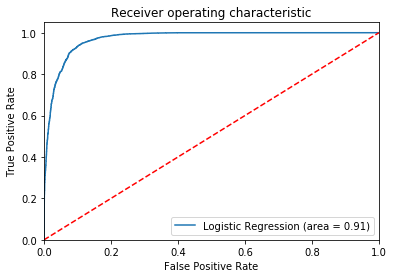

In [21]:
logreg = run_regression_accuracy(X_train, y_train, X_test, y_test)

In [22]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.coef_


C:\Users\Ameen\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[0.00025718, 0.00081695, 0.00841411]])

In [23]:
logreg.intercept_

array([-4.01876858])

In [24]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred2 = rf.predict(X_test)

#Aunder the curve score
roc2 = roc_auc_score(y_test, y_pred2)

roc2

0.8997333210013565

**The random forest classfier model gave us an auc score of .89 vs the auc score of .91 with the logistic regression model The classification report also shows greater scores under the logistic regression model**

In [31]:
print('\nClassification report: \n',classification_report(y_test, y_pred2))


Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.83      0.87      3816
           1       0.93      0.97      0.95      9350

   micro avg       0.93      0.93      0.93     13166
   macro avg       0.93      0.90      0.91     13166
weighted avg       0.93      0.93      0.93     13166



In [32]:
conf2 = confusion_matrix(y_test, y_pred2)
conf2

array([[3163,  653],
       [ 275, 9075]], dtype=int64)

In [27]:
rf.feature_importances_

array([0.1643531 , 0.36891862, 0.46672828])

# Conclusion

To my suprise I can determine if a player is going to win in first simply by viewing the distance they walked, the distance they drove a vehicle, and how much damage the player commited; with great accuracy. 